In [28]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import konlpy

from konlpy.tag import Mecab

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


%matplotlib inline

#### 데이터 분석

In [130]:
path_to_train = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_train.txt'
path_to_test = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_test.txt'

train_data = pd.read_table(path_to_train)
test_data = pd.read_table(path_to_test)

print(len(train_data))
print(len(test_data))

train_data.head()

150000
50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [131]:
# NaN 값을 제거하고, 모든 데이터를 문자열로 변환
train_data = train_data.dropna()  # NaN 값 제거
train_data['document'] = train_data['document'].astype(str)

test_data = test_data.dropna()  # NaN 값 제거
test_data['document'] = test_data['document'].astype(str)

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


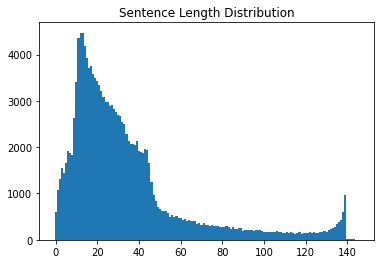

In [132]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['document']:
    length = len(sen)
    if min_len > length: 
        min_len = length
    if max_len < length: 
        max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data['document']))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [133]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(train_data['document'], 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿
음
?
?
ㅎ
굿
ㅋ
굿
즐
♥
굳
ㅋ
네
ㅎ
ㅋ
굿
ㅇ
k
.
굿
굿
굳
ㅠ
?
1
ㅋ
굿
쒯
굿
굿
굳
♬
굿
토
ㅋ
ㅋ
굿
ㅋ
굿
O
똥
ㅎ
.
굿
ㅎ
짱
굳
굿
굿
짱
?
z
굿
짱
음
굳
ㅇ
헐
굳
굳
굿
굿
굿
삼
꽝
굿
굿
굿
굿
ㅎ
굳
굿
4
!
?
ㅎ
1
굳
.
ㅎ
풉
아
굿
똥
ㅅ
왜
ㄴ
굳
쉣
봐
z


Data Size: 146339
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


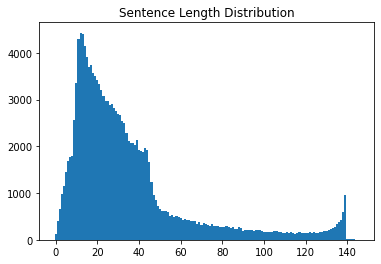

In [134]:
min_len = 999
max_len = 0
sum_len = 0

# train_data['document']와 train_data['label']의 중복 제거
cleaned_train = list(set(zip(train_data['document'], train_data['label'])))  # (document, label) 쌍으로 묶어 중복 제거
cleaned_documents, cleaned_labels = zip(*cleaned_train)  # 다시 documents와 labels로 분리

# 중복 제거된 데이터 크기 출력
print("Data Size:", len(cleaned_documents))

for sen in cleaned_documents:
    length = len(sen)
    if min_len > length: 
        min_len = length
    if max_len < length: 
        max_len = length
    sum_len += length

# 문장의 최단, 최장, 평균 길이 출력
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_documents))

# 문장의 길이에 따른 분포 시각화
sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_documents:  # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [135]:
cleaned_test = list(test_data['document'])
print(len(cleaned_test))

49997


#### SentencePiece 사용하기

In [136]:
!pip install sentencepiece

In [137]:
import sentencepiece as spm

# 리스트를 텍스트 파일로 저장
with open("data/cleaned_train.txt", "w", encoding="utf-8") as f:
    for sentence in cleaned_documents:
        f.write(sentence + "\n")  # 문장마다 줄바꿈 추가
        
vocab_size = 12000

# SentencePiece 모델 학습
spm.SentencePieceTrainer.train(
    input="data/cleaned_train.txt",
    model_prefix="korean_spm",
    vocab_size=vocab_size,
    model_type="unigram"
)

In [138]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds(cleaned_documents[0])
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces(cleaned_documents[0], 1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[4, 8, 19, 230, 3230, 15, 3591, 159, 2629, 54, 38]
['▁', '...', '다', '된', '밥', '에', '▁찬', '성', '뿌', '리', '기']
...다된밥에 찬성뿌리기


In [139]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    return tensor, word_index, index_word

In [140]:
X_train = sp_tokenize(s, cleaned_documents)[0]
X_test = sp_tokenize(s, cleaned_test)[0]

y_train = np.array(cleaned_labels)
y_test = np.array(test_data['label'])

In [141]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 이상치 제거
maxlen = int(np.mean(num_tokens) + 2.5 * np.std(num_tokens))
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < maxlen) / len(num_tokens)} %가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  16.053057004319125
문장길이 최대 :  132
문장길이 표준편차 :  13.80032561091109
pad_sequences maxlen :  50
전체 문장의 0.953187393040502 %가 maxlen 설정값 이내에 포함됩니다. 


In [142]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=0,
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=0,
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146339, 50)
(49997, 50)


#### 모델 설계 & train-validation set split

In [143]:
# validation set 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape)
print(y_train.shape)

(117071, 50)
(117071,)


In [144]:
# 모델 구성
# exploration 5에서 찾은 최적의 model configuration으로 실험
embed_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    embed_dim, 
                                    input_length=maxlen))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(56, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(56, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(56)))
model.add(tf.keras.layers.Dense(56, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 100)           1200000   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 50, 112)           53088     
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 50, 112)           57120     
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 112)               57120     
_________________________________________________________________
dense_14 (Dense)             (None, 56)                6328      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 57        
Total params: 1,373,713
Trainable params: 1,373,713
Non-trainable params: 0
____________________________________________

In [145]:
checkpoint = ModelCheckpoint("weights.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=2, 
                               verbose=1, 
                               restore_best_weights=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/20
229/229 [==============================] - 16s 37ms/step - loss: 0.4182 - accuracy: 0.8047 - val_loss: 0.3485 - val_accuracy: 0.8501

Epoch 00001: val_accuracy improved from -inf to 0.85014, saving model to weights.h5
Epoch 2/20
229/229 [==============================] - 7s 30ms/step - loss: 0.3062 - accuracy: 0.8709 - val_loss: 0.3358 - val_accuracy: 0.8565

Epoch 00002: val_accuracy improved from 0.85014 to 0.85646, saving model to weights.h5
Epoch 3/20
229/229 [==============================] - 7s 30ms/step - loss: 0.2669 - accuracy: 0.8905 - val_loss: 0.3327 - val_accuracy: 0.8546

Epoch 00003: val_accuracy did not improve from 0.85646
Epoch 4/20
229/229 [==============================] - 7s 31ms/step - loss: 0.2289 - accuracy: 0.9086 - val_loss: 0.3519 - val_accuracy: 0.8526

Epoch 00004: val_accuracy did not improve from 0.85646
Epoch 5/20
229/229 [==============================] - 7s 31ms/step - loss: 0.1946 - accuracy: 0.9234 - val_loss: 0.4002 - val_accuracy: 0.8452

In [146]:
# load weights from 'weights.h5'
model.load_weights('weights.h5')

results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1563/1563 - 9s - loss: 0.3400 - accuracy: 0.8540
[0.3399910628795624, 0.8539912104606628]


#### sentencepiece tokenizer의 vocab_size 변화에 따른 tokenizer 모델의 성능 비교

1. unigram
    - 6000 : 85.30
    - 8000 : 85.38
    - 10000 : 85.29
    - 12000 : 85.40
<br><br>
2. bpe
    - 6000 : 85.04
    - 8000 : 85.28
    - 10000 : 85.31
    - 12000 : 85.34